Using device: cuda


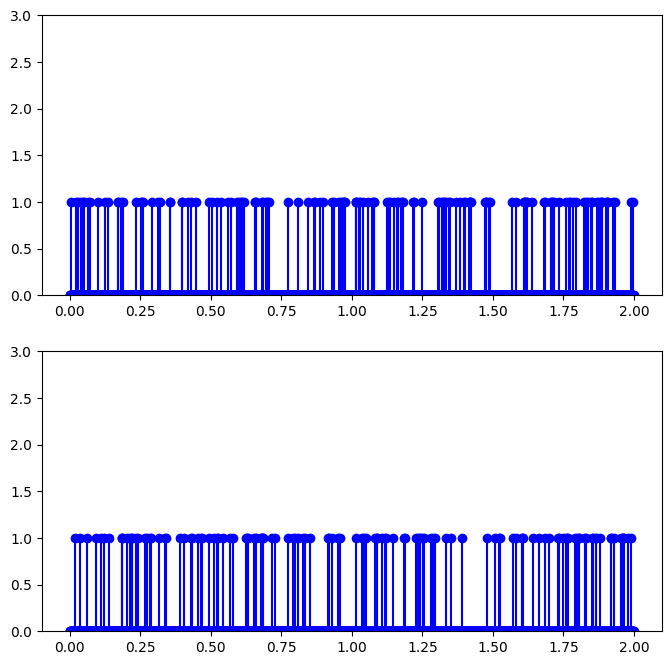

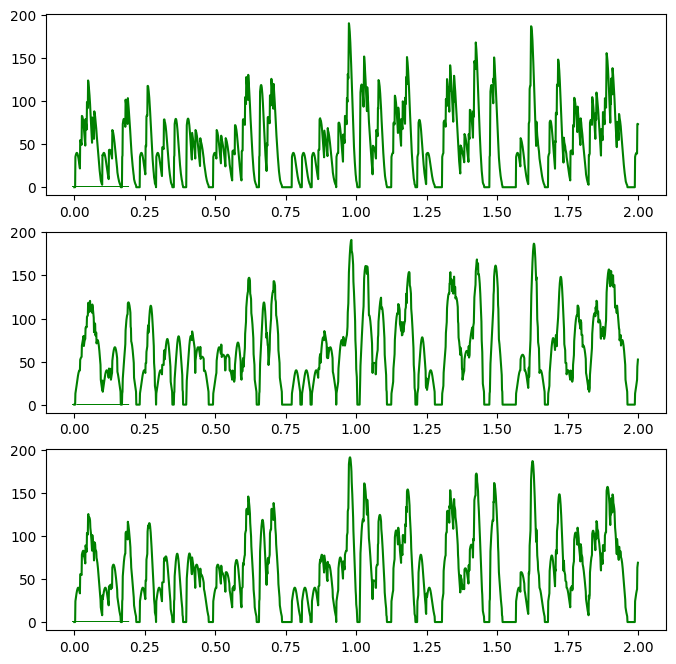

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

%run ../src/models/losses.py
%run ../src/data/data_generator.py


In [8]:
class SparseAutoencoder(nn.Module):
    def __init__(self, sources, channels, duration, sampling_frequency):
        super().__init__()
        self.sources = sources
        self.channels = channels
        self.duration = duration
        self.sampling_frequency = sampling_frequency
        self.num_samples = int(duration * sampling_frequency)

        # Create DataGenerator instance
        self.data_generator = DataGenerator(
            sources=sources,
            channels=channels,
            duration=duration,
            sampling_frequency=sampling_frequency
        )
        
        # Encoder network (Y -> z)
        self.encoder = nn.Sequential(
            nn.Conv1d(channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, sources, kernel_size=3, padding=1),
            nn.Sigmoid(),  # Map to [0,1]
        )

    def to(self, device):
        super().to(device)
        self.device = device
        return self
    
    
    def encode(self, y):
        z = self.encoder(y)
        # Make predictions binary
        z = (z > 0.5).float()
        return z
    
    def decode(self, z, H):
        # H should be of shape (batch, channels, sources, filter_length)
        # z should be of shape (batch, sources, time)
        
        # Convolve z with H
        batch_size = z.shape[0]
        y_hat = torch.zeros(batch_size, self.channels, self.num_samples).to(z.device)
        
        for b in range(batch_size):
            for c in range(self.channels):
                for s in range(self.sources):
                    y_hat[b,c] += F.conv1d(
                        z[b,s:s+1], 
                        H[b,c,s:s+1].flip(-1).unsqueeze(0), 
                        padding='same'
                    ).squeeze(0)
        
        return y_hat
    
    def forward(self, y, H):
        z = self.encode(y)
        z = z.requires_grad_(True)
        y_hat = self.decode(z, H)
        y_hat = y_hat.requires_grad_(True)
        return y_hat, z 
    
def generate_batch_data(data_generator, batch_size, device):
    """Generate a batch of data using DataGenerator"""
    X_batch = []
    H_batch = []
    Y_batch = []
    
    for _ in range(batch_size):
        # Generate random firing rates
        firing_rates = np.random.randint(1, 5, (data_generator.num_sources))
        
        # Generate random filter parameters
        L = 30  # filter length
        mu_H = np.random.uniform(0.005, 0.015, (data_generator.num_channels, data_generator.num_sources))
        sigma_H = np.random.uniform(0.01, 0.015, (data_generator.num_channels, data_generator.num_sources))
        
        # Generate single example
        emg, spike_trains, filter = data_generator.generate_data(
            firing_rates=firing_rates,
            filter_length=L,
            mu_H=mu_H,
            sigma_H=sigma_H
        )
        
        X_batch.append(spike_trains)
        H_batch.append(filter)
        Y_batch.append(emg)
    
    # Convert to tensors and move to device
    X = torch.tensor(np.stack(X_batch), dtype=torch.float32, requires_grad=False).to(device)
    H = torch.tensor(np.stack(H_batch), dtype=torch.float32, requires_grad=False).to(device)
    Y = torch.tensor(np.stack(Y_batch), dtype=torch.float32, requires_grad=False).to(device)
    
    return X, H, Y

def loss_function(y_hat, y, z, x, gamma=1.0):
    """Loss function combining reconstruction and Hungarian matching"""
    # Ensure tensors require gradients
    y_hat = y_hat.requires_grad_(True)
    z = z.requires_grad_(True)

    # Reconstruction loss
    recon_loss = F.mse_loss(y_hat, y)
    
    # Hungarian matching loss between z and x
    losses = Losses()
    loss_fn = losses.total_loss
    hungarian_loss = losses.hungarian_loss(z, x, loss_fn=loss_fn)
    
    total_loss = recon_loss + gamma * hungarian_loss
    
    return total_loss, recon_loss, hungarian_loss
           

In [3]:
def plot_signals(x, y, z, h, iteration, show_filters=True):
    """Detailed plot of signals and filters"""
    #move to cpu before plotting
    x = x.detach().cpu()
    y = y.detach().cpu()
    z = z.detach().cpu()
    h = h.detach().cpu()

    if show_filters:
        fig, axes = plt.subplots(4, 1, figsize=(15, 15))
    else:
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot original sources (X)
    ax = axes[0]
    for s in range(x.shape[1]):
        ax.plot(x[0, s].cpu().detach().numpy(), label=f'Source {s+1}')
    ax.set_title('Original Sources (X)')
    ax.legend()
    ax.grid(True)
    
    # Plot mixed signals (Y)
    ax = axes[1]
    for c in range(y.shape[1]):
        ax.plot(y[0, c].cpu().detach().numpy(), label=f'Channel {c+1}', alpha=0.5)
    ax.set_title('Mixed Signals (Y)')
    ax.legend()
    ax.grid(True)
    
    # Plot predicted sources (Z)
    ax = axes[2]
    for s in range(z.shape[1]):
        ax.plot(z[0, s].cpu().detach().numpy(), label=f'Predicted {s+1}')
    ax.set_title('Predicted Sources (Z)')
    ax.legend()
    ax.grid(True)
    
    # Plot filters if requested
    if show_filters:
        ax = axes[3]
        for c in range(min(3, h.shape[1])):  # Show first 3 channels only
            for s in range(h.shape[2]):
                ax.plot(h[0, c, s].cpu().detach().numpy(), 
                       label=f'H[ch{c+1},src{s+1}]', 
                       alpha=0.7)
        ax.set_title('Mixing Filters (H) - First 3 Channels')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle(f'Iteration {iteration}')
    plt.show()

def plot_loss_history(train_losses, recon_losses, hungarian_losses):
    """Plot detailed loss history"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Total Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(recon_losses)
    plt.title('Reconstruction Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(hungarian_losses)
    plt.title('Hungarian Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def print_statistics(x, z, y, y_hat, iteration, loss_stats):
    """Print detailed statistics about the current state"""
    # Move tensors to CPU for statistics calculation
    x = x.detach().cpu()
    z = z.detach().cpu()
    y = y.detach().cpu()
    y_hat = y_hat.detach().cpu()
    
    print(f"\n{'='*20} Iteration {iteration} {'='*20}")
    
    # Print loss values
    print("\nLoss Values:")
    print(f"Total Loss: {loss_stats['total']:.4f}")
    print(f"Reconstruction Loss: {loss_stats['recon']:.4f}")
    print(f"Hungarian Loss: {loss_stats['hungarian']:.4f}")
    print(f"Learning Rate: {loss_stats['lr']:.6f}")
    
    # Print signal statistics
    print("\nSignal Statistics:")
    print("Original Sources (X):")
    print(f"  Mean: {x.mean():.4f}, Std: {x.std():.4f}")
    print(f"  Max: {x.max():.4f}, Min: {x.min():.4f}")
    print(f"  Sparsity: {(x == 0).float().mean():.4f}")
    
    print("\nPredicted Sources (Z):")
    print(f"  Mean: {z.mean():.4f}, Std: {z.std():.4f}")
    print(f"  Max: {z.max():.4f}, Min: {z.min():.4f}")
    print(f"  Sparsity: {(z == 0).float().mean():.4f}")
    
    print("\nMixed Signals (Y):")
    print(f"  Mean: {y.mean():.4f}, Std: {y.std():.4f}")
    print(f"  Max: {y.max():.4f}, Min: {y.min():.4f}")
    
    print("\nReconstructed Signals (Y_hat):")
    print(f"  Mean: {y_hat.mean():.4f}, Std: {y_hat.std():.4f}")
    print(f"  Max: {y_hat.max():.4f}, Min: {y_hat.min():.4f}")
    
    print("\nReconstruction Error:")
    print(f"  MSE: {F.mse_loss(y, y_hat):.4f}")
    print(f"  MAE: {F.l1_loss(y, y_hat):.4f}")
    print("-" * 60)

In [4]:
def train_model(model, num_iterations=1000, batch_size=32, lr=0.001, plot_every=50):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    train_losses = []
    recon_losses = []
    hungarian_losses = []

    # Initialize timing variables
    start_time = time.time()
    last_print_time = start_time
    
    for iteration in range(num_iterations):
        model.train()
        
        # Generate new batch of training data
        x, h, y = generate_batch_data(model.data_generator, batch_size, device)
        
        optimizer.zero_grad()
        
        # Forward pass
        y_hat, z = model(y, h)
        
        # Compute loss
        loss, recon_loss, hung_loss = loss_function(y_hat, y, z, x)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Record losses
        train_losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        hungarian_losses.append(hung_loss.item())
        
        # Plot and print progress
        if iteration % plot_every == 0:
            current_time = time.time()
            elapsed_time = current_time - start_time
            time_per_iter = elapsed_time / (iteration + 1)
            remaining_iters = num_iterations - iteration - 1
            estimated_time_remaining = remaining_iters * time_per_iter
            
            # Convert to hours, minutes, seconds
            elapsed_hours, rem = divmod(elapsed_time, 3600)
            elapsed_minutes, elapsed_seconds = divmod(rem, 60)
            
            remaining_hours, rem = divmod(estimated_time_remaining, 3600)
            remaining_minutes, remaining_seconds = divmod(rem, 60)
            
            # Calculate iterations per second
            iters_per_second = plot_every / (current_time - last_print_time)
            last_print_time = current_time
            
            # Print timing information
            print("\nTiming Information:")
            print(f"Iteration: {iteration}/{num_iterations} ({iteration/num_iterations*100:.1f}%)")
            print(f"Iterations per second: {iters_per_second:.2f}")
            print(f"Elapsed time: {int(elapsed_hours)}h {int(elapsed_minutes)}m {int(elapsed_seconds)}s")
            print(f"Estimated time remaining: {int(remaining_hours)}h {int(remaining_minutes)}m {int(remaining_seconds)}s")

            # Collect loss statistics
            loss_stats = {
                'total': loss.item(),
                'recon': recon_loss.item(),
                'hungarian': hung_loss.item(),
                'lr': optimizer.param_groups[0]['lr']
            }
            
            # Print detailed statistics
            print_statistics(x, z, y, y_hat, iteration, loss_stats)
            
            # Plot signals and filters
            plot_signals(x, y, z, h, iteration)
            
            # Plot loss history
            plot_loss_history(train_losses, recon_losses, hungarian_losses)
        
        scheduler.step(loss.item())

    # Print final timing information
    total_time = time.time() - start_time
    hours, rem = divmod(total_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"\nTraining completed in: {int(hours)}h {int(minutes)}m {int(seconds)}s")
    print(f"Average time per iteration: {total_time/num_iterations:.3f}s")
    
    return train_losses, recon_losses, hungarian_losses

In [5]:
sources = 2
channels = 10
duration = 2
sampling_frequency = 20
model = SparseAutoencoder(sources, channels, duration, sampling_frequency)
#have to be careful about firing rates as depending on what they are set to, they can invert the model

# Print model's device location
print(f"Model device before moving: {next(model.parameters()).device}")
model = model.to(device)
print(f"Model device after moving: {next(model.parameters()).device}")

# Train with detailed visualization every 50 iterations
losses, recon_losses, hung_losses = train_model(
    model, 
    num_iterations=1000,
    batch_size=32, 
    lr=0.001, 
    plot_every=50
)

Model device before moving: cpu
Model device after moving: cuda:0


RuntimeError: Given groups=1, weight of size [2, 1, 30], expected input[1, 2, 41] to have 1 channels, but got 2 channels instead

Spike times shape: (16, 2)
First few spike times:
 [[0.16310272 0.020398  ]
 [0.86797492 0.0314561 ]
 [1.05534613 0.15162726]
 [1.20905142 0.19736301]
 [1.35450097 0.20318645]]

Spike trains shape: (2, 200)
Unique values in spike trains: [0 1]


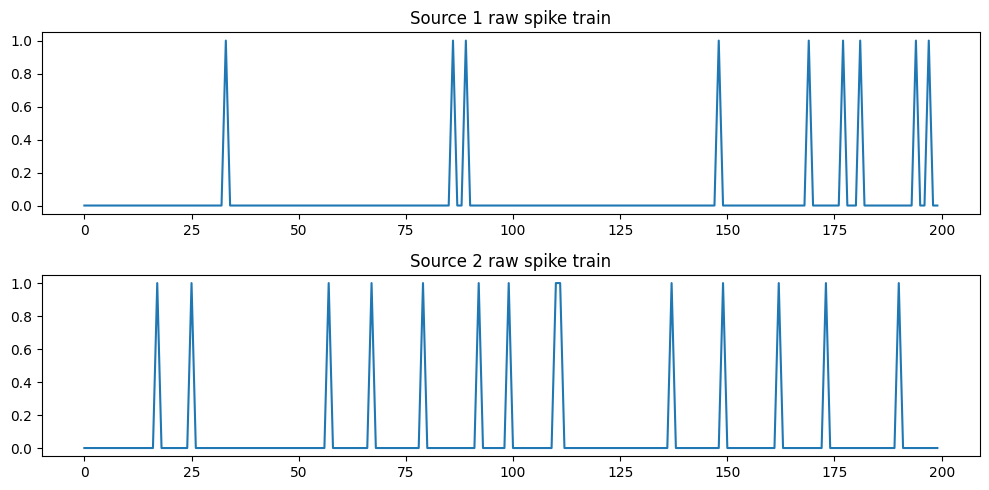

In [83]:
# Debug test
data_generator = DataGenerator(sources=2, channels=10, duration=2, sampling_frequency=100)

# Generate a single example
firing_rates = np.random.randint(1, 10, (data_generator.num_sources))
L = 30
mu_H = np.random.uniform(0.005, 0.015, (data_generator.num_channels, data_generator.num_sources))
sigma_H = np.random.uniform(0.01, 0.015, (data_generator.num_channels, data_generator.num_sources))

# Generate and plot each step
spike_times = data_generator.generate_spike_times_poisson(firing_rates)
print("Spike times shape:", spike_times.shape)
print("First few spike times:\n", spike_times[:5])

spike_trains = data_generator.spike_times_to_trains(spike_times)
print("\nSpike trains shape:", spike_trains.shape)
print("Unique values in spike trains:", np.unique(spike_trains))

X, Y, _ = data_generator.generate_data(firing_rates=firing_rates, filter_length=L, mu_H=mu_H, sigma_H=sigma_H)


# Plot the raw spike trains
plt.figure(figsize=(10, 5))
for i in range(data_generator.num_sources):
    plt.subplot(2, 1, i+1)
    plt.plot(Y[i])
    plt.title(f"Source {i+1} raw spike train")
plt.tight_layout()
plt.show()